# Import libraries

In [21]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [22]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.13.0


In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler
import librosa
import pywt

# Load data

In [24]:
# Load the data from the files
training_data = np.load('/kaggle/input/training/training_data.npy')
valid_periods = np.load('/kaggle/input/training/valid_periods.npy')
categories = np.load('/kaggle/input/training/categories.npy')

training_data.shape, valid_periods.shape, categories.shape

((48000, 2776), (48000, 2), (48000,))

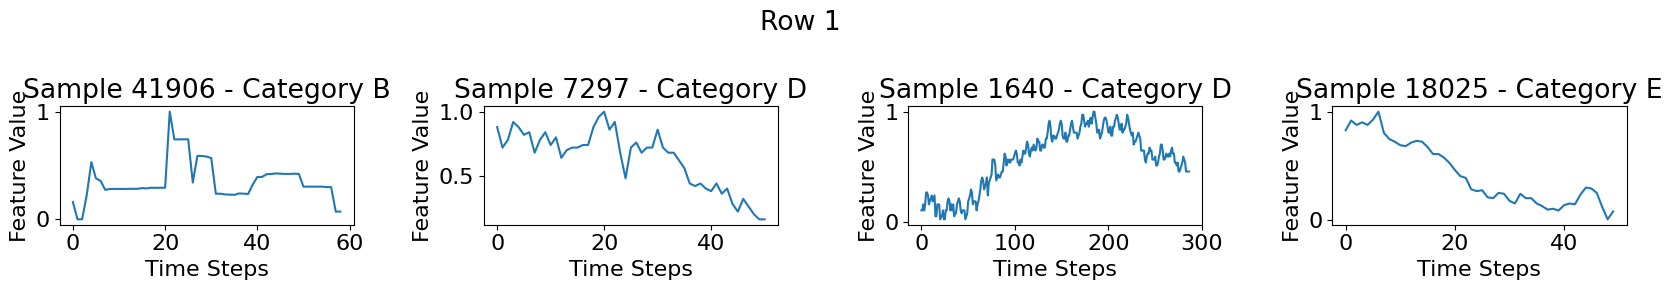

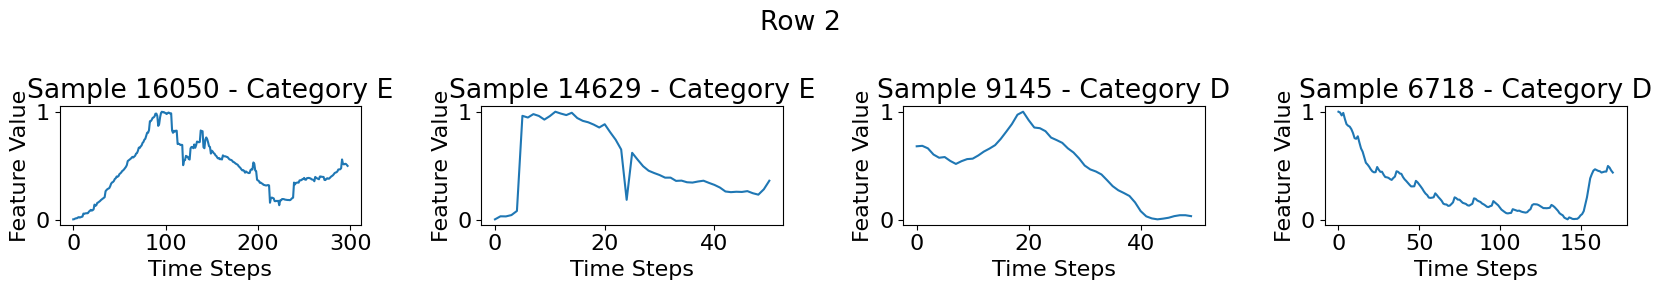

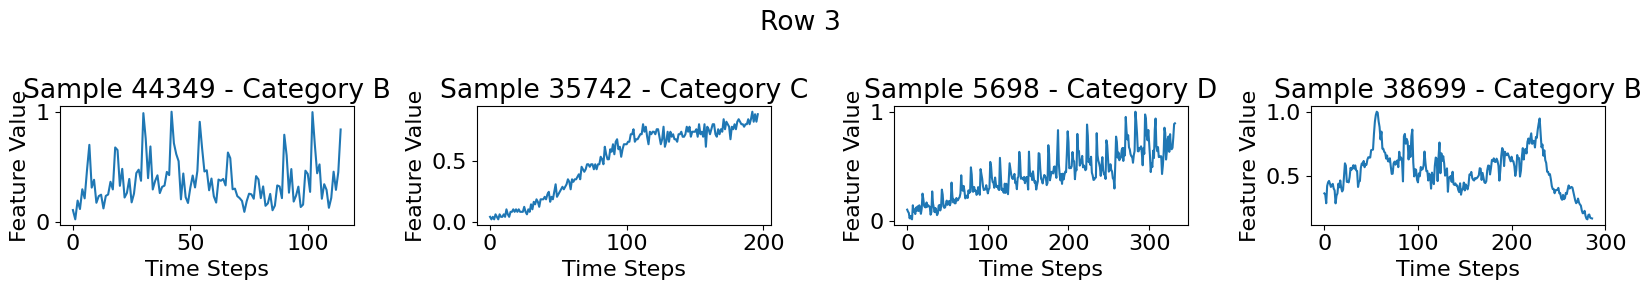

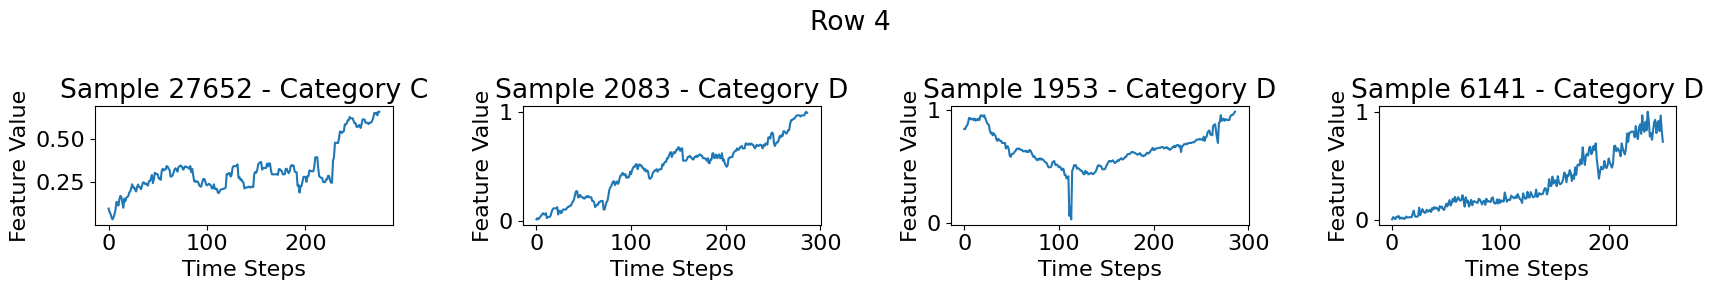

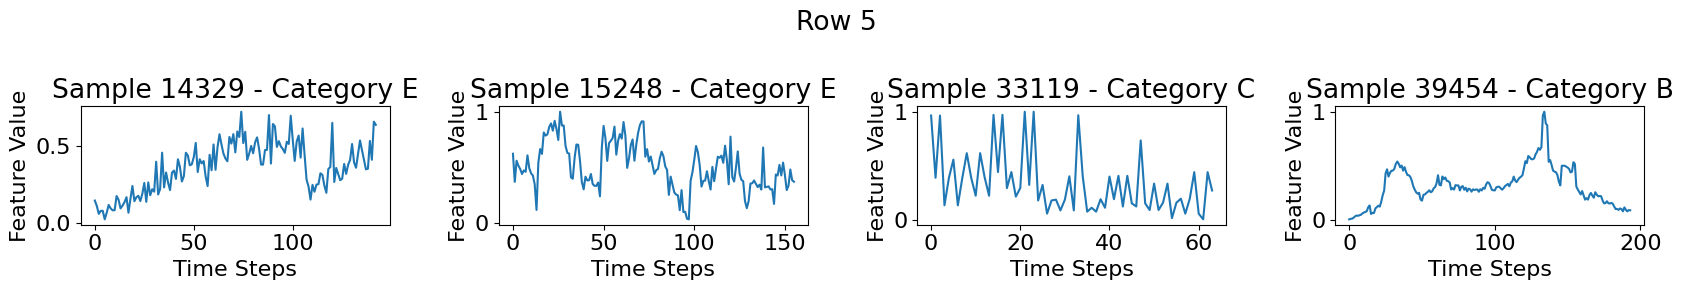

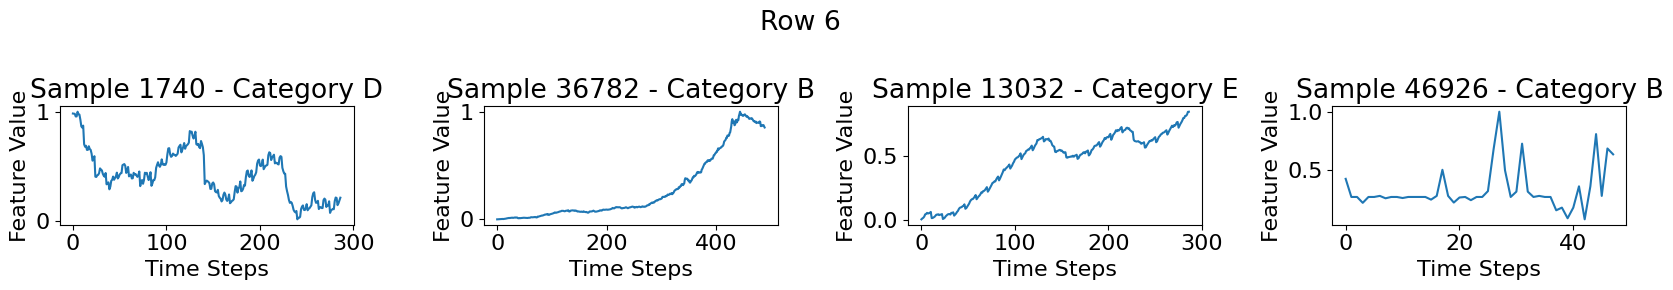

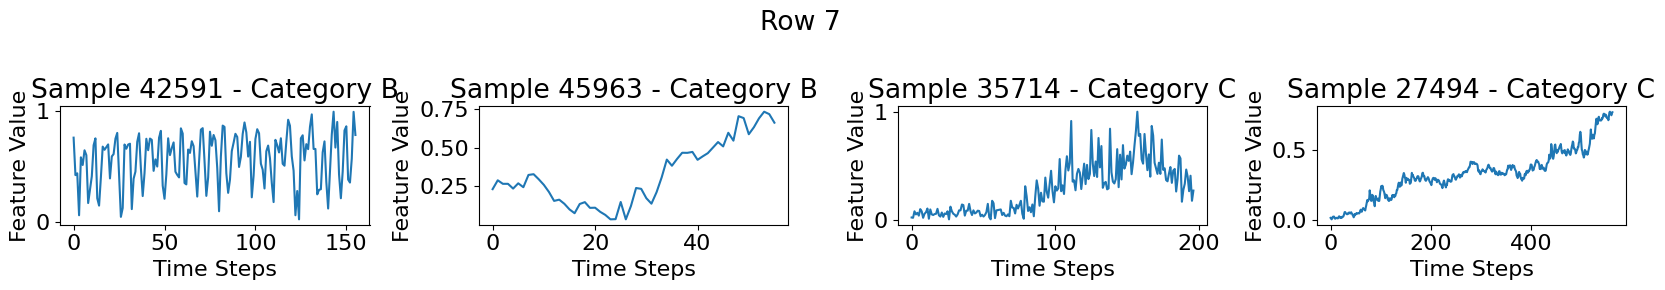

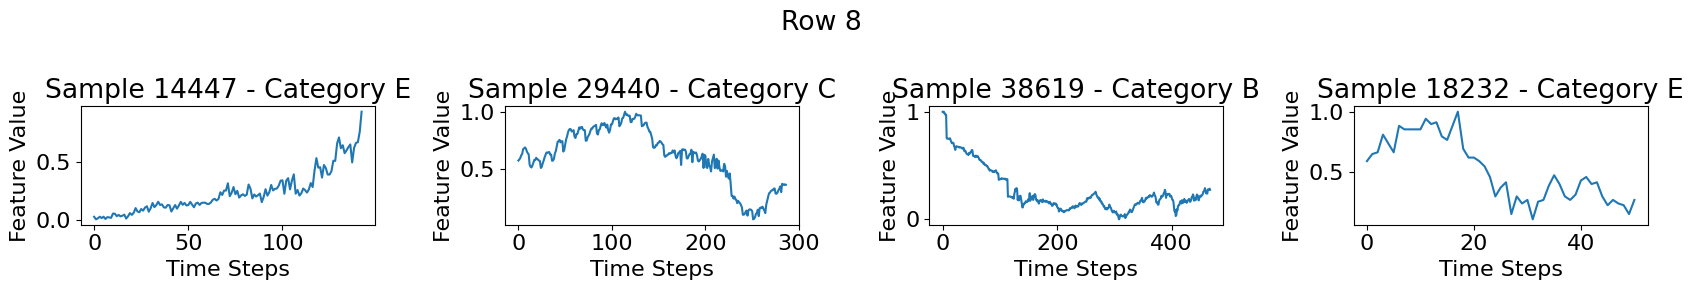

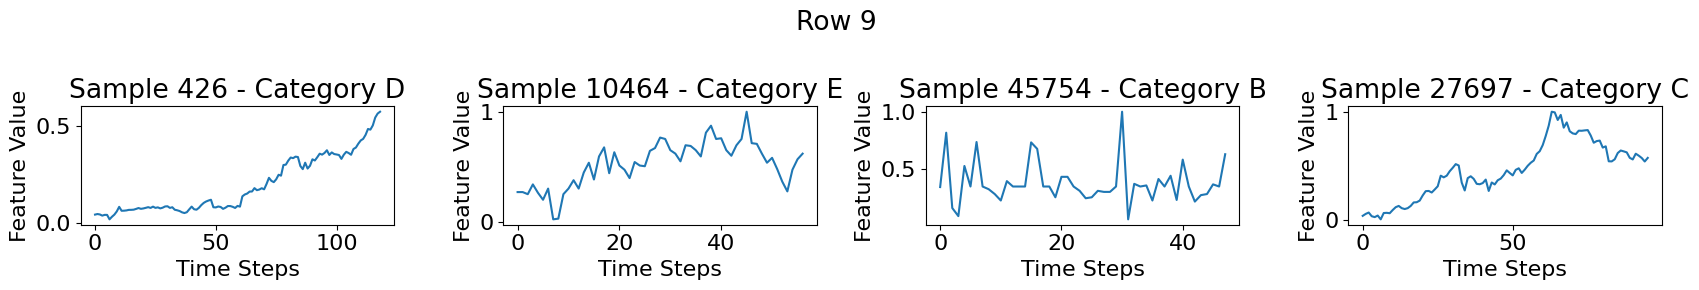

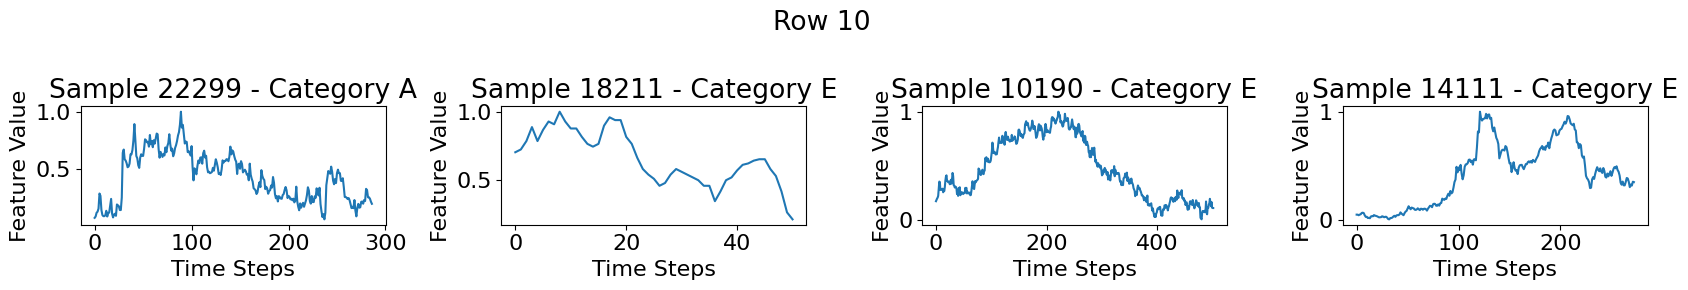

In [25]:
# Plot N rows of samples,4 samples per row

N = 10

# indices = range(100) # First 100 samples
indices = [random.randint(0, len(training_data) - 1) for _ in range(N * 4)]

num_samples_per_row = 4
num_rows = len(indices) // num_samples_per_row

for row in range(num_rows):
    plt.figure(figsize=(17, 3))
    plt.suptitle(f'Row {row + 1}')

    for col in range(num_samples_per_row):
        idx = row * num_samples_per_row + col

        if idx >= len(indices):
            break

        sample_idx = indices[idx]

        # Find the non-zero indices in the time series
        non_zero_indices = np.nonzero(training_data[sample_idx])[0]

        # Trim the time series to remove padding
        trimmed_series = training_data[sample_idx, non_zero_indices]

        plt.subplot(1, num_samples_per_row, col + 1)
        plt.plot(trimmed_series)
        plt.title(f'Sample {sample_idx + 1} - Category {categories[sample_idx]}')
        plt.xlabel('Time Steps')
        plt.ylabel('Feature Value')

    plt.tight_layout()
    plt.show()


# Extract features

In [31]:
def extract_statistical_features(time_series_data):
    features = [
        np.mean(time_series_data),
        np.median(time_series_data),
        np.std(time_series_data),
        skew(time_series_data),
        kurtosis(time_series_data),
        np.min(time_series_data),
        np.max(time_series_data),
        np.ptp(time_series_data),  # Peak-to-Peak
    ]
    return features

def extract_frequency_domain_features(time_series_data):
    fft_result = np.fft.fft(time_series_data)
    amplitude_spectrum = np.abs(fft_result)
    
    features = [
        np.mean(amplitude_spectrum),
        np.std(amplitude_spectrum),
        np.argmax(amplitude_spectrum),  # Dominant frequency index
        np.max(amplitude_spectrum),     # Dominant frequency amplitude
    ]
    
    return features

def extract_wavelet_features(time_series_data):
    # Using Discrete Wavelet Transform (DWT)
    coeffs = pywt.dwt(time_series_data, 'db1')
    cA, cD = coeffs  # Approximation coefficients, Detail coefficients
    
    features = [
        np.mean(cA),
        np.std(cA),
        np.mean(cD),
        np.std(cD),
    ]
    
    return features

def extract_mfcc_features(time_series_data, sr):
    # Using Mel-frequency cepstral coefficients (MFCC)
    mfccs = librosa.feature.mfcc(y=time_series_data, sr=sr, n_mfcc=13)
    
    # Take the mean of each coefficient across time
    features = [np.mean(mfcc) for mfcc in mfccs]
    
    return features

def remove_padding(time_series_data):
    non_zero_indices = np.nonzero(time_series_data)[0]
    trimmed_series = time_series_data[non_zero_indices]
    return trimmed_series

# zagladivanje funkcije?

def extract_all_features(time_series_data, sr):
    time_series_data = remove_padding(time_series_data)
    
    stat_features = extract_statistical_features(time_series_data)
    freq_features = extract_frequency_domain_features(time_series_data)
    wavelet_features = extract_wavelet_features(time_series_data)
    mfcc_features = extract_mfcc_features(time_series_data, sr)

    # Combine all features
    all_features = stat_features + freq_features + wavelet_features + mfcc_features
    
    return all_features

In [32]:
features = []

for idx in range(len(training_data)):
    # Find the non-zero indices in the time series
    non_zero_indices = np.nonzero(training_data[idx])[0]

    # Trim the time series to remove padding
    trimmed_series = training_data[idx, non_zero_indices]
    
    features.append(extract_all_features(trimmed_series, 1000))
    
    if ((idx + 1) % 1000 == 0):
        print(f'{idx + 1}/{len(training_data)}')

1000/48000
2000/48000
3000/48000
4000/48000
5000/48000
6000/48000
7000/48000
8000/48000
9000/48000
10000/48000
11000/48000
12000/48000
13000/48000
14000/48000
15000/48000
16000/48000
17000/48000
18000/48000
19000/48000
20000/48000
21000/48000
22000/48000
23000/48000
24000/48000
25000/48000
26000/48000
27000/48000
28000/48000
29000/48000
30000/48000
31000/48000
32000/48000
33000/48000
34000/48000
35000/48000
36000/48000
37000/48000
38000/48000
39000/48000
40000/48000
41000/48000
42000/48000
43000/48000
44000/48000
45000/48000
46000/48000
47000/48000
48000/48000


In [34]:
# Save features

features_array = np.array(features)
np.save('features.npy', features_array)

In [43]:
features_array.shape, training_data.shape

((48000, 29), (48000, 2776))

# KMeans

In [44]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# Flatten the time series data
training_data_flatten = training_data.reshape(training_data.shape[0], -1)

# Standardize the features
scaler = StandardScaler()
features_array_standardized = scaler.fit_transform(features_array)

# Choose the number of clusters (in your case, 9)
n_clusters = 9

# Create and fit KMeans model
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(features_array_standardized)

# Get cluster labels
cluster_labels = kmeans.labels_

# Evaluate the clustering performance using silhouette score
silhouette_avg = silhouette_score(features_array_standardized, cluster_labels)
print(f'Silhouette Score: {silhouette_avg:.2f}')

# Now you can use the cluster labels for further analysis or visualization

Silhouette Score: 0.10


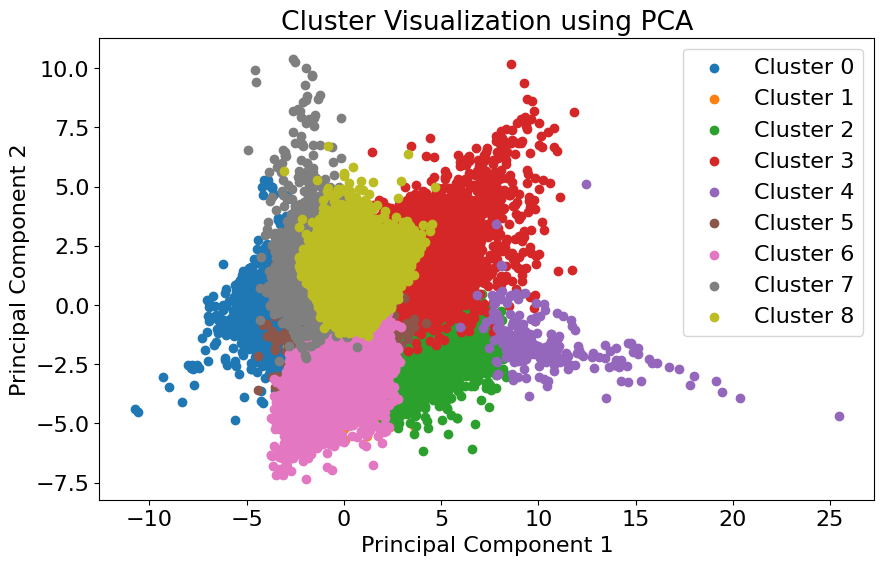

In [45]:
# Reduce dimensionality using PCA for visualization
pca = PCA(n_components=2)
features_array_pca = pca.fit_transform(features_array_standardized)

# Plot the clusters
plt.figure(figsize=(10, 6))
for cluster_label in range(n_clusters):
    cluster_points = features_array_pca[cluster_labels == cluster_label]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster_label}')

plt.title('Cluster Visualization using PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

In [50]:
cluster_labels

array([6, 6, 8, ..., 6, 6, 5], dtype=int32)

In [ ]:
import joblib

autoencoder.save('autoencoder_model.h5')  # Saves the entire model
encoder.save('encoder_model.h5')  # Saves the encoder model
joblib.dump(kmeans, 'kmeans_model.pkl')  # Saves the KMeans model


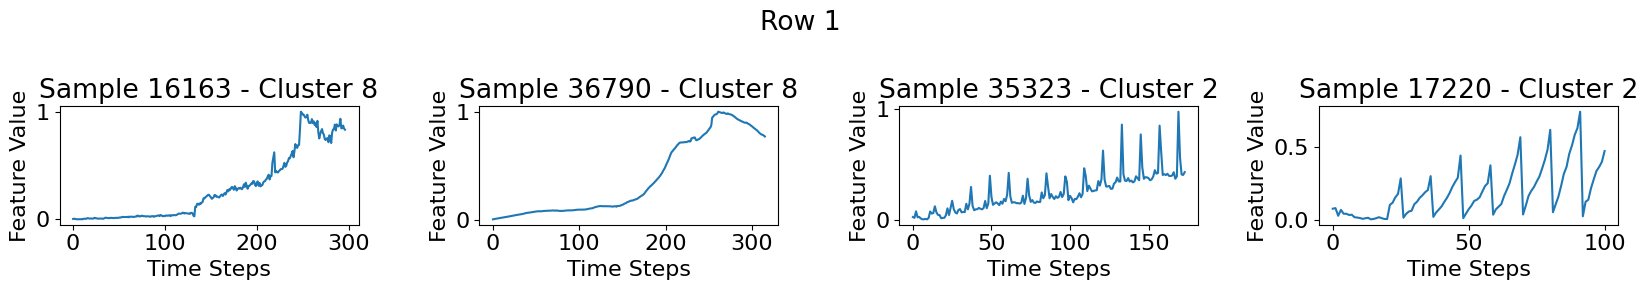

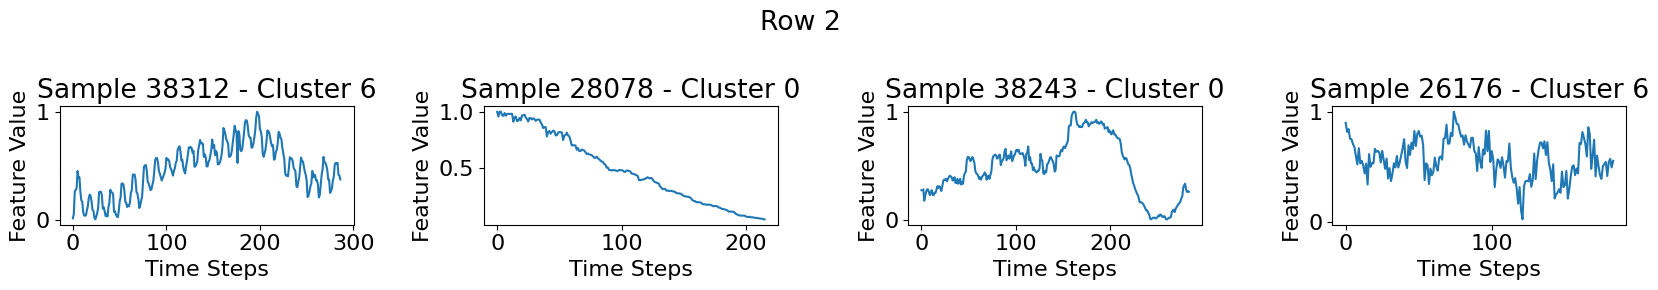

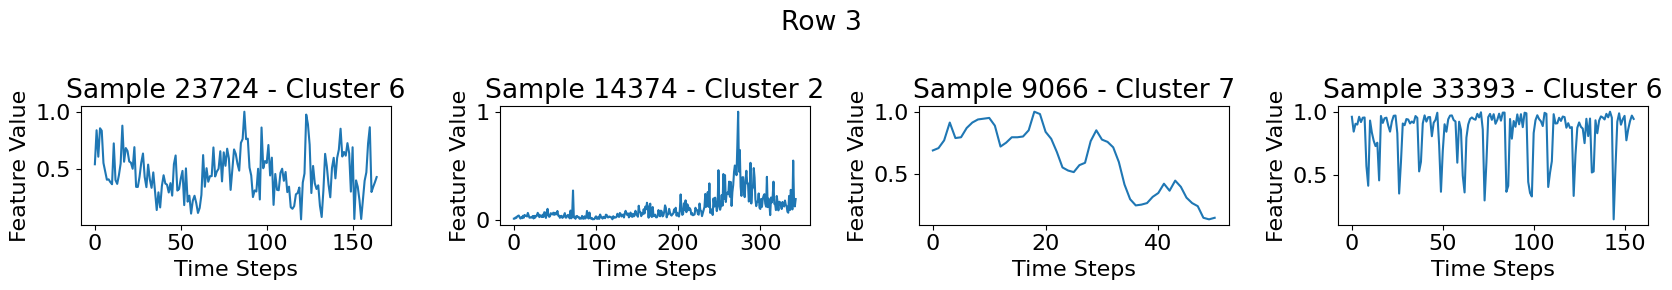

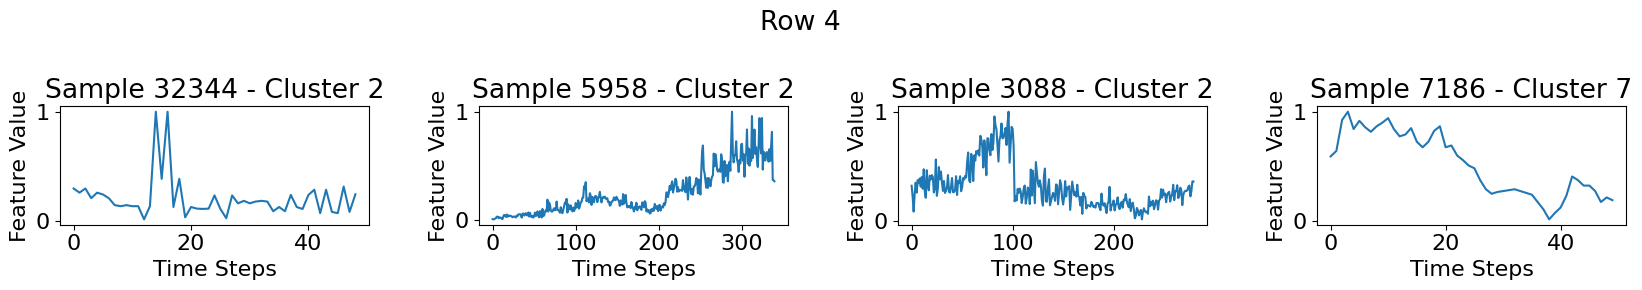

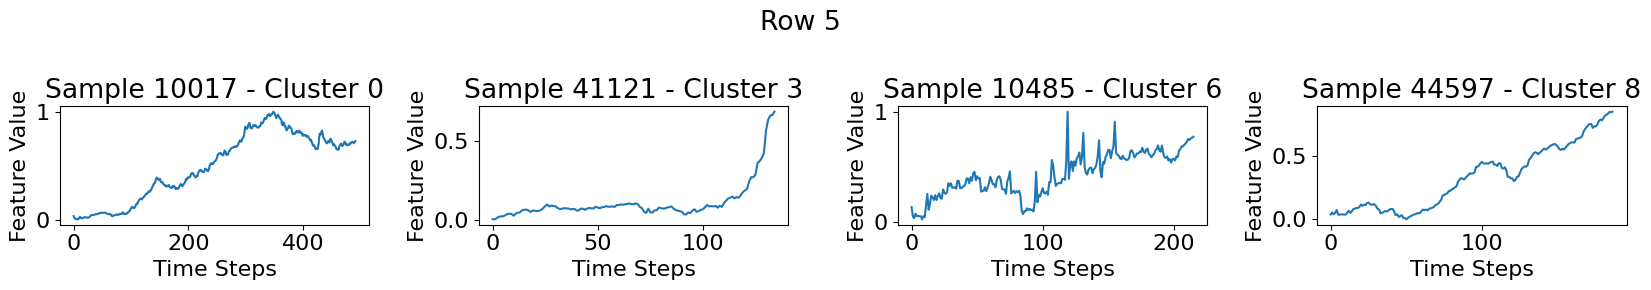

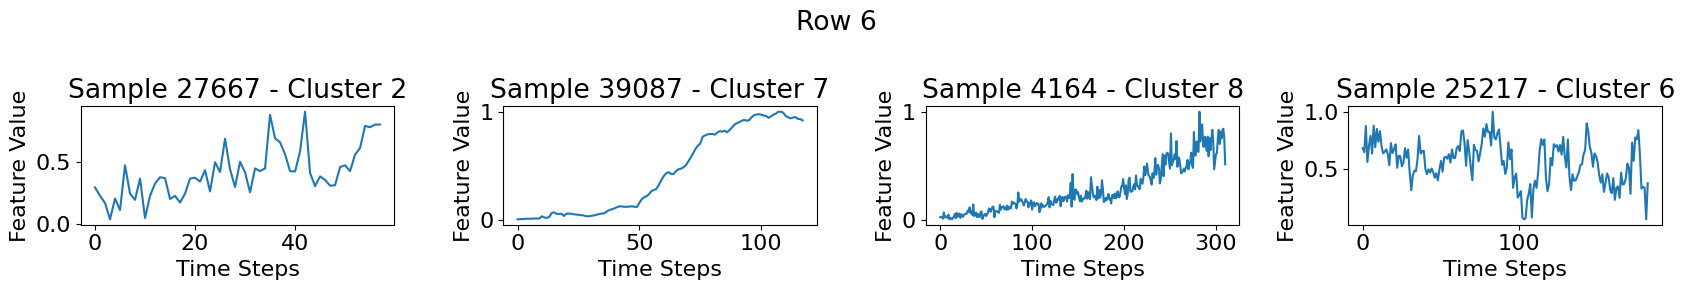

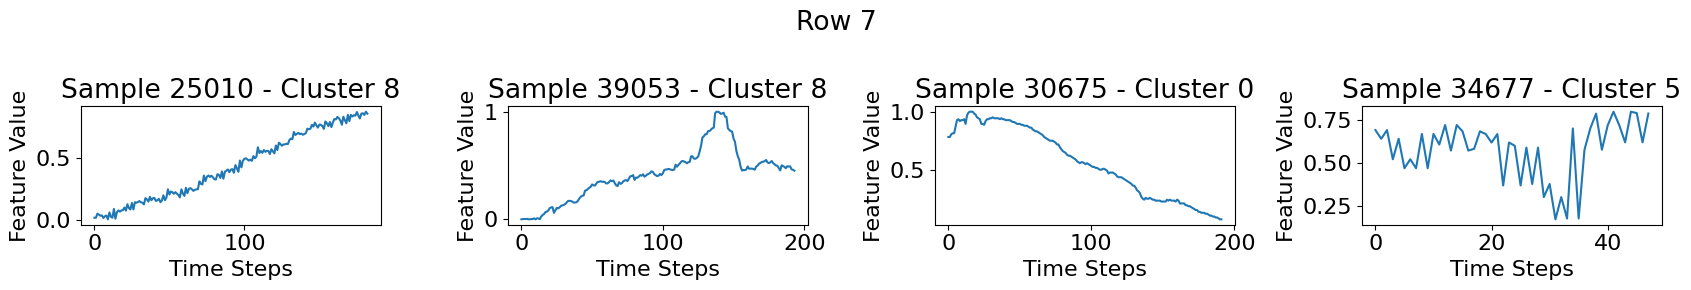

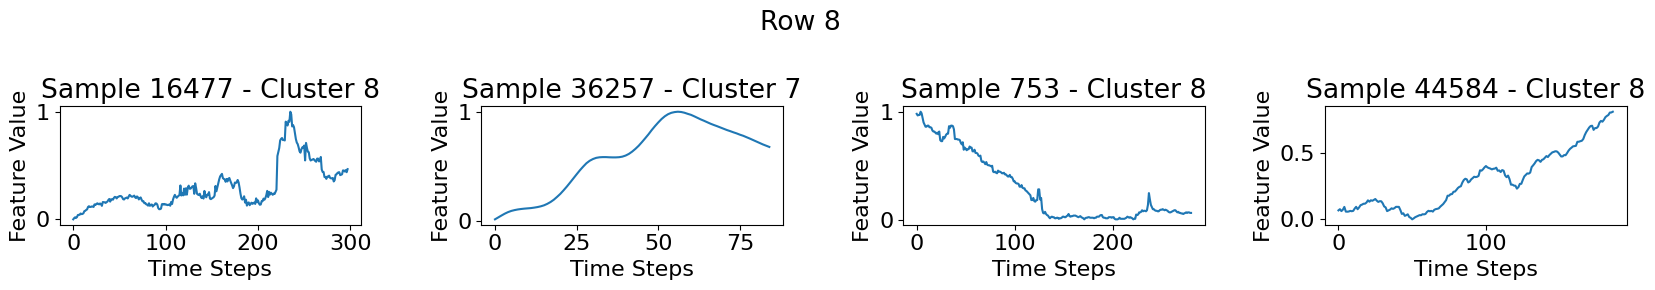

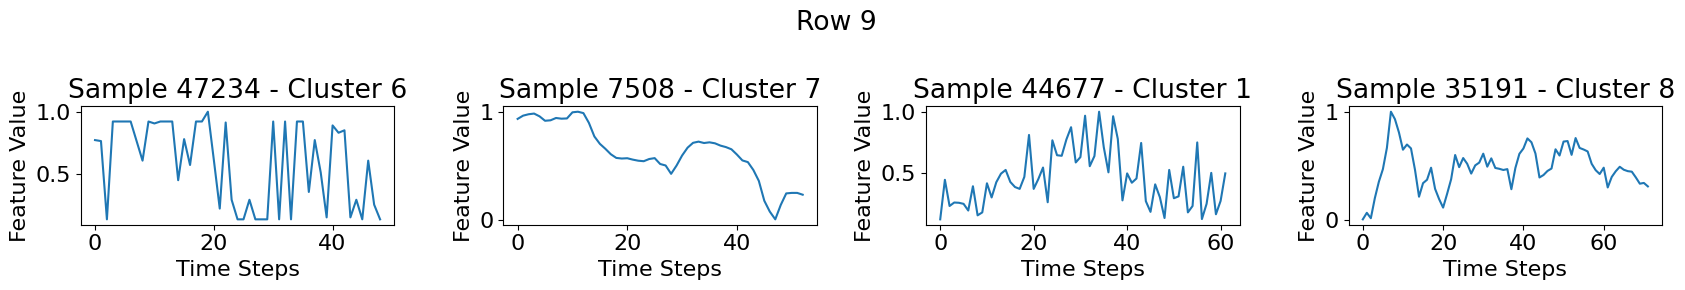

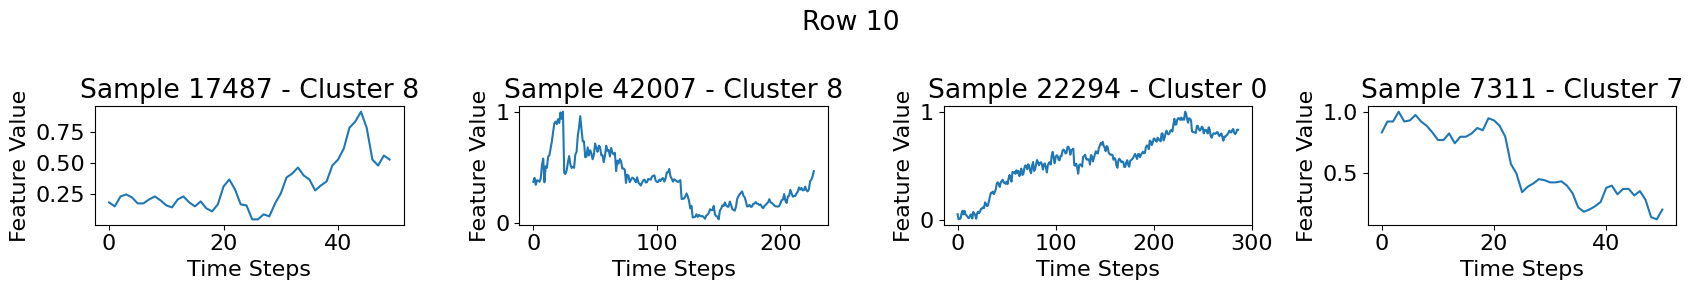

In [53]:
# Plot N rows of samples,4 samples per row

N = 10

# indices = range(100) # First 100 samples
indices = [random.randint(0, len(training_data) - 1) for _ in range(N * 4)]

num_samples_per_row = 4
num_rows = len(indices) // num_samples_per_row

for row in range(num_rows):
    plt.figure(figsize=(17, 3))
    plt.suptitle(f'Row {row + 1}')

    for col in range(num_samples_per_row):
        idx = row * num_samples_per_row + col

        if idx >= len(indices):
            break

        sample_idx = indices[idx]

        # Find the non-zero indices in the time series
        non_zero_indices = np.nonzero(training_data[sample_idx])[0]

        # Trim the time series to remove padding
        trimmed_series = training_data[sample_idx, non_zero_indices]

        plt.subplot(1, num_samples_per_row, col + 1)
        plt.plot(trimmed_series)
        plt.title(f'Sample {sample_idx + 1} - Cluster {cluster_labels[sample_idx]}')
        plt.xlabel('Time Steps')
        plt.ylabel('Feature Value')

    plt.tight_layout()
    plt.show()


20579 [2725 2776]


<Figure size 1700x300 with 0 Axes>

40244 [2733 2776]


<Figure size 1700x300 with 0 Axes>

19004 [2725 2776]


<Figure size 1700x300 with 0 Axes>

34374 [2712 2776]


<Figure size 1700x300 with 0 Axes>

40682 [2631 2776]


<Figure size 1700x300 with 0 Axes>

36673 [2554 2776]


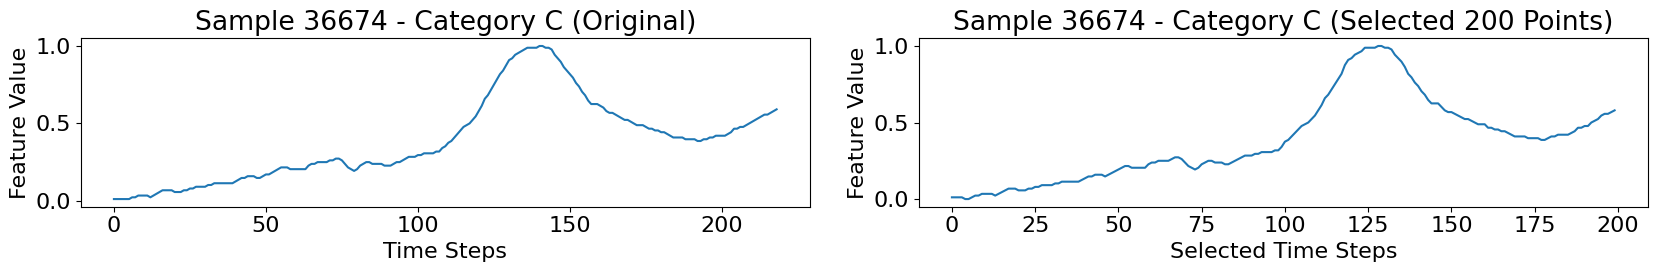

37350 [2536 2776]


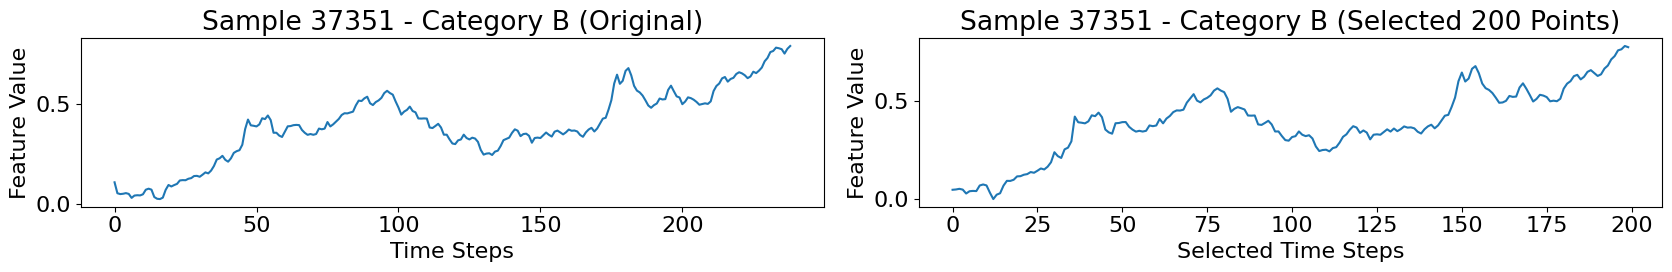

21980 [2488 2776]


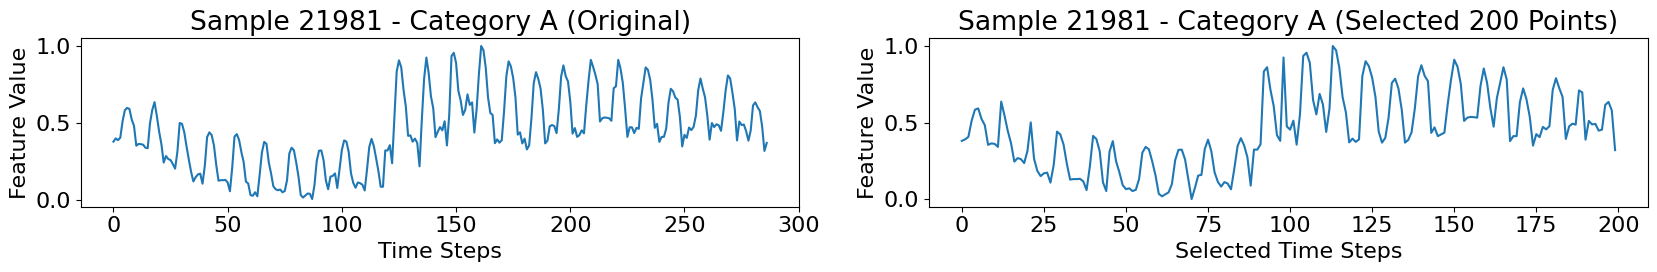

40089 [2368 2776]


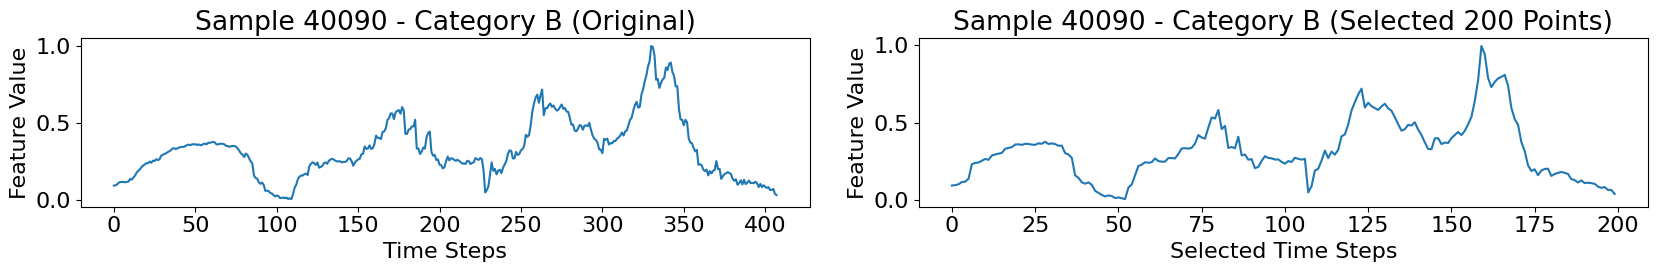

25786 [2603 2776]


<Figure size 1700x300 with 0 Axes>

22851 [2488 2776]


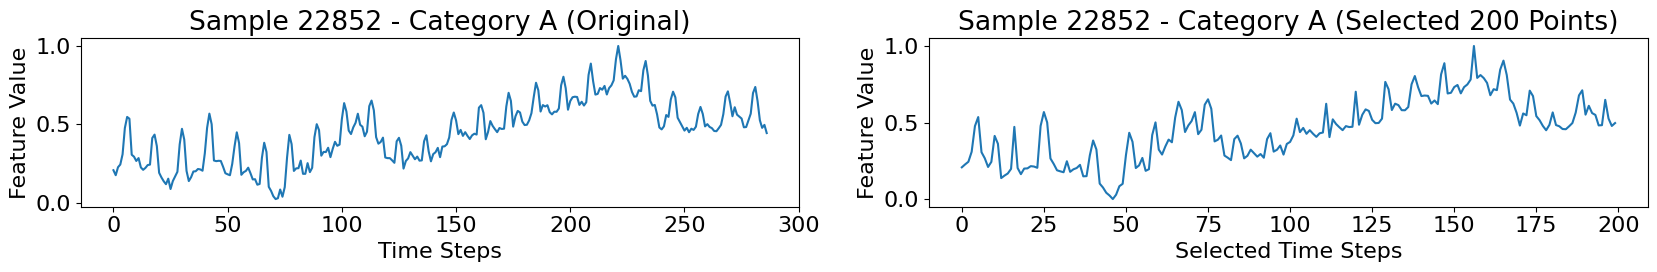

18461 [2715 2776]


<Figure size 1700x300 with 0 Axes>

27128 [2212 2776]


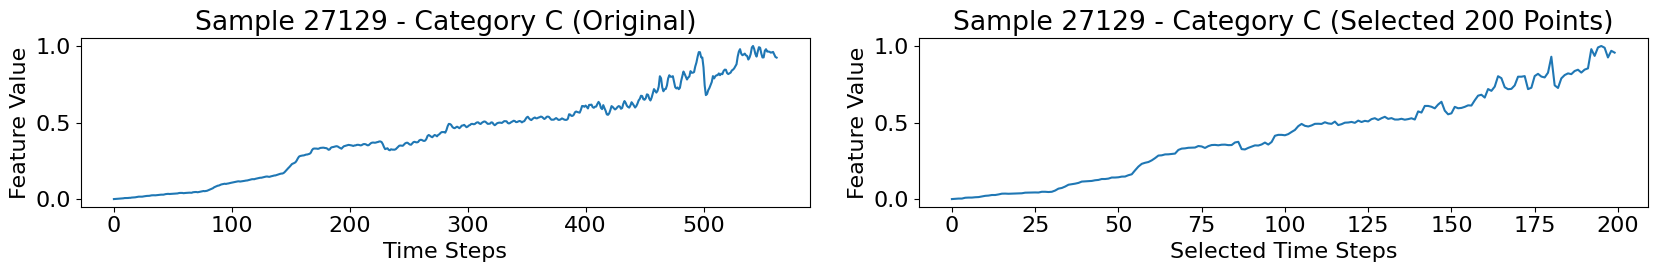

43087 [2712 2776]


<Figure size 1700x300 with 0 Axes>

28483 [2560 2776]


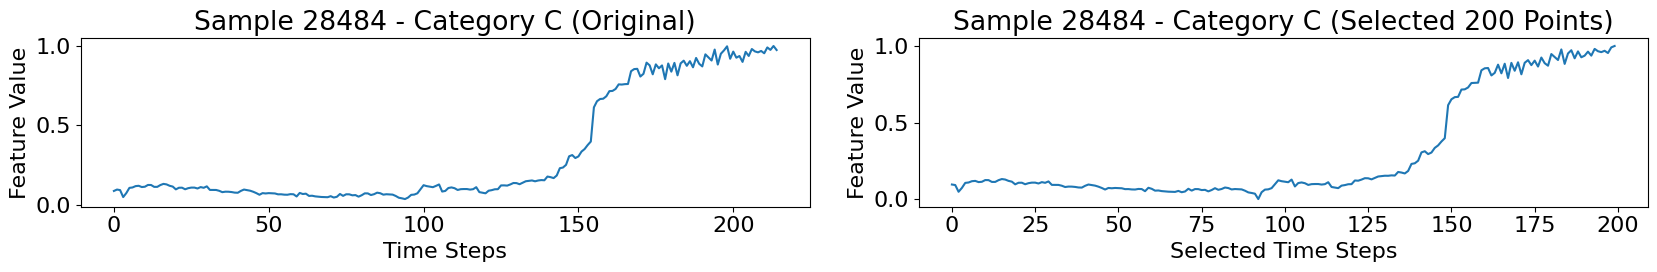

16253 [2477 2776]


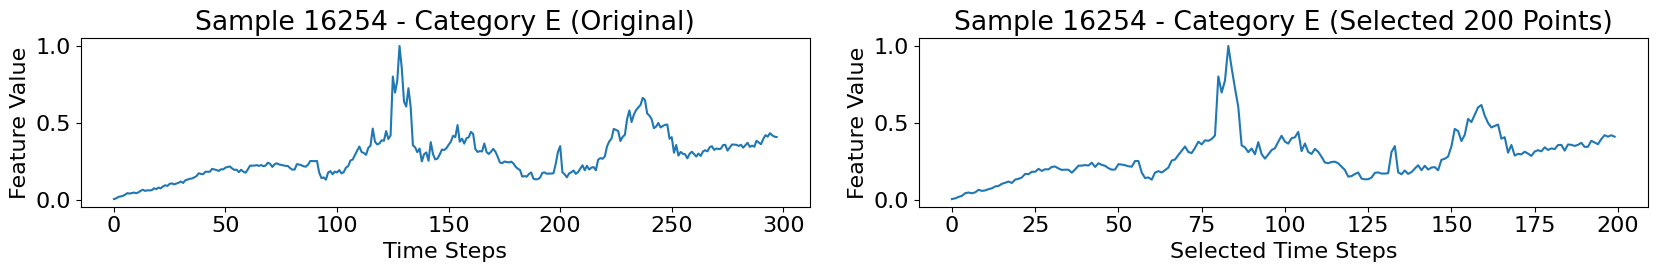

19564 [2725 2776]


<Figure size 1700x300 with 0 Axes>

21653 [2089 2776]


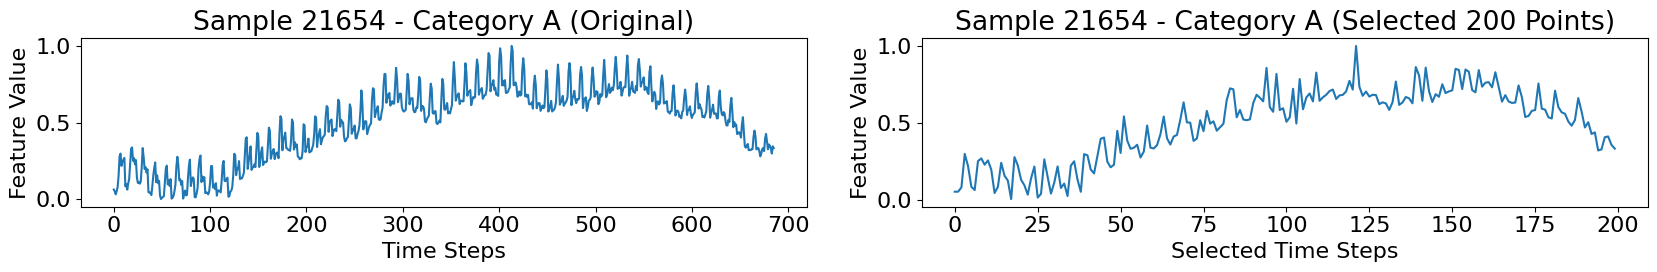

17152 [2657 2776]


<Figure size 1700x300 with 0 Axes>

19146 [2725 2776]


<Figure size 1700x300 with 0 Axes>

In [78]:
import random
import numpy as np
import matplotlib.pyplot as plt

N = 10

# Assuming you have training_data, categories, etc. defined

# indices = range(100) # First 100 samples
indices = [random.randint(0, len(training_data) - 1) for _ in range(N * 2)]  # Reduced to N * 2 for one sample and its reduced version

num_samples_per_row = 1
num_rows = len(indices) // num_samples_per_row

for row in range(num_rows):
    plt.figure(figsize=(17, 3))
    
    for col in range(num_samples_per_row):
        idx = row * num_samples_per_row + col

        if idx >= len(indices):
            break

        sample_idx = indices[idx]

        # Find the non-zero indices in the time series
        non_zero_indices = np.nonzero(training_data[sample_idx])[0]

        # Trim the time series to remove padding
        trimmed_series = training_data[sample_idx, non_zero_indices]

        # Select random 200 points from the non-padding part
        print(sample_idx, valid_periods[sample_idx])
        
        if (valid_periods[sample_idx][1] - valid_periods[sample_idx][0] < 200):
            break
        
        selected_indices = random.sample(range(valid_periods[sample_idx][0], valid_periods[sample_idx][1] - 1), 200)
        selected_indices.sort()
        selected_200_points = training_data[sample_idx, selected_indices]

        # Plot original sample
        plt.subplot(1, num_samples_per_row * 2, col * 2 + 1)
        plt.plot(trimmed_series)
        plt.title(f'Sample {sample_idx + 1} - Category {categories[sample_idx]} (Original)')
        plt.xlabel('Time Steps')
        plt.ylabel('Feature Value')

        # Plot selected 200 points
        plt.subplot(1, num_samples_per_row * 2, col * 2 + 2)
        plt.plot(selected_200_points)
        plt.title(f'Sample {sample_idx + 1} - Category {categories[sample_idx]} (Selected 200 Points)')
        plt.xlabel('Selected Time Steps')
        plt.ylabel('Feature Value')

    plt.tight_layout()
    plt.show()


In [77]:
count = 0

for period in valid_periods:
    if (period[1] - period[0] < 200):
        count += 1
        
count, len(valid_periods)

(24943, 48000)